In [1]:
import pandas as pd
import numpy as np
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#for word embedding
import gensim
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [32]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd

def twenty_newsgroup_to_csv():
    newsgroups_train = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

    df = pd.DataFrame([newsgroups_train.data, newsgroups_train.target.tolist()]).T
    df.columns = ['text', 'target']

    targets = pd.DataFrame( newsgroups_train.target_names)
    targets.columns=['title']

    out = pd.merge(df, targets, left_on='target', right_index=True)
    out['date'] = pd.to_datetime('now')
    out.to_csv('20_newsgroup.csv')
    
twenty_newsgroup_to_csv()

C:\Users\carlo\.conda\envs\PBR_22\lib\site-packages\pandas\core\arrays\datetimes.py:2199: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  result, tz_parsed = tslib.array_to_datetime(


In [33]:
data = pd.read_csv('20_newsgroup.csv', index_col = 0)

In [34]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
df_train, df_test = train_test_split(data,test_size=0.2,shuffle=True)

In [11]:
! pip install seaborn

  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

9     811
13    808
15    802
12    800
6     798
1     795
11    795
10    789
3     786
14    783
8     780
7     780
2     773
5     760
4     756
17    751
16    737
0     651
18    612
19    509
Name: target, dtype: int64


C:\Users\carlo\.conda\envs\PBR_22\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='target'>

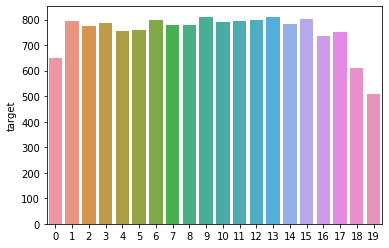

In [35]:
x=df_train['target'].value_counts()
print(x)
sns.barplot(x.index,x)

In [39]:
df_train.isna().sum()

text          0
target        0
title         0
date          0
word_count    0
dtype: int64

In [37]:
# WORD-COUNT
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
print(df_train[df_train['target']==1]['word_count'].mean()) #Disaster tweets
print(df_train[df_train['target']==0]['word_count'].mean()) #Non-Disaster tweets

179.95849056603774
199.32258064516128


In [38]:
df_train = df_train.dropna()

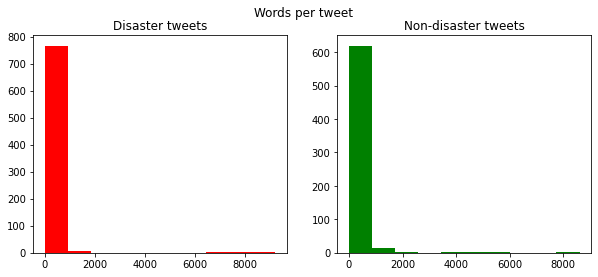

In [40]:
# PLOTTING WORD-COUNT
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['target']==1]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Disaster tweets')
train_words=df_train[df_train['target']==0]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Non-disaster tweets')
fig.suptitle('Words per tweet')
plt.show()

In [41]:
# CHARACTER-COUNT
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
print(df_train[df_train['target']==1]['char_count'].mean()) #Disaster tweets
print(df_train[df_train['target']==0]['char_count'].mean()) #Non-Disaster tweets

1199.5076923076922
1217.1921875


In [44]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)
#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [45]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))
df_train['clean_text'] = df_train['text'].apply(lambda x: finalpreprocess(x))
df_train.head()

,text,target,title,date,word_count,char_count,clean_text
12442,Hi-\nDo any of you hardware gurus out there kn...,4,comp.sys.mac.hardware,2022-04-03 10:35:12.269940,122,703,hi hardware guru know kind memory architecture...
16608,"For those who pray in tongues,\n\n When i...",15,soc.religion.christian,2022-04-03 10:35:12.269940,29,164,pray tongue appropriate pray speak tongue woul...
10158,I feel compelled to complain: the statement th...,14,sci.space,2022-04-03 10:35:12.269940,475,2783,feel compel complain statement recent observat...
1523,FOR SALE\n\nPC TOOLS VERSION 7.1\n\nAll origin...,6,misc.forsale,2022-04-03 10:35:12.269940,21,142,sale pc tool version original disk manual incl...
7138,\nIt will certainly *help* to be able to run W...,2,comp.os.ms-windows.misc,2022-04-03 10:35:12.269940,87,460,certainly help able run windows dos apps way s...


In [46]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(df_train["clean_text"],df_train["target"],test_size=0.2,shuffle=True)
#Word2Vec
# Word2Vec runs on tokenized sentences
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

In [51]:
#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)
#building Word2Vec model
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))
def fit(self, X, y):
        return self
def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

df_train['clean_text_tok']=[nltk.word_tokenize(i) for i in df_train['clean_text']]
model = Word2Vec(df_train['clean_text_tok'],min_count=1)    
w2v = dict(zip(model.wv.index_to_key, model.wv.syn0)) 
modelw = MeanEmbeddingVectorizer(w2v)
# converting text to numerical data using Word2Vec
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_test_tok)

AttributeError: 'KeyedVectors' object has no attribute 'syn0'

In [58]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, balanced_accuracy_score

svm_acc = accuracy_score(y_test, y_predict)
svm_f1 = f1_score(y_test, y_predict, average ='weighted')
svm_bacc = balanced_accuracy_score(y_test, y_predict)

print(f"Test Accuracy of Logistic Regression(tf-idf) is {svm_acc} \n")
print(f"Test Balanced Accuracy of Logistic Regression(tf-idf) is {svm_bacc} \n")
print(f"Test F1-score weighted of Logistic Regression(tf-idf) is {svm_f1} \n")

              precision    recall  f1-score   support

           0       0.67      0.62      0.64       141
           1       0.70      0.73      0.71       171
           2       0.65      0.65      0.65       151
           3       0.64      0.63      0.64       154
           4       0.76      0.74      0.74       151
           5       0.75      0.72      0.74       133
           6       0.73      0.75      0.74       169
           7       0.80      0.76      0.78       157
           8       0.65      0.74      0.69       151
           9       0.89      0.81      0.85       154
          10       0.92      0.89      0.90       159
          11       0.82      0.79      0.81       155
          12       0.66      0.77      0.71       149
          13       0.83      0.89      0.86       167
          14       0.80      0.75      0.77       155
          15       0.76      0.79      0.77       150
          16       0.63      0.73      0.67       126
          17       0.82    

In [59]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

svm_acc = accuracy_score(y_test, y_predict)
svm_f1 = f1_score(y_test, y_predict, average ='weighted')
svm_bacc = balanced_accuracy_score(y_test, y_predict)

print(f"Test Accuracy of Naive Bayes(tf-idf) is {svm_acc} \n")
print(f"Test Balanced Accuracy of Naive Bayes(tf-idf) is {svm_bacc} \n")
print(f"Test F1-score weighted of Naive Bayes(tf-idf) is {svm_f1} \n")

              precision    recall  f1-score   support

           0       0.91      0.23      0.36       141
           1       0.70      0.68      0.69       171
           2       0.69      0.58      0.63       151
           3       0.53      0.79      0.64       154
           4       0.88      0.64      0.74       151
           5       0.81      0.76      0.78       133
           6       0.76      0.66      0.70       169
           7       0.85      0.73      0.78       157
           8       0.85      0.66      0.75       151
           9       0.90      0.85      0.88       154
          10       0.90      0.89      0.90       159
          11       0.61      0.86      0.72       155
          12       0.73      0.72      0.72       149
          13       0.88      0.81      0.84       167
          14       0.86      0.74      0.79       155
          15       0.33      0.95      0.49       150
          16       0.57      0.83      0.67       126
          17       0.77    